In [29]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [30]:
## defining a frame for image and mask storage

framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)

    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])

    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [31]:
# loading benign samples
framObj = LoadData( framObjTrain, imgPath = 'Dataset_BUSI_with_GT/benign'
                        , maskPath = 'Dataset_BUSI_with_GT/benign'
                         , shape = 256)

In [32]:
# loading malignant samples
framObj = LoadData( framObjTrain, imgPath = 'Dataset_BUSI_with_GT/malignant'
                        , maskPath = 'Dataset_BUSI_with_GT/malignant'
                         , shape = 256)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(framObj['img'], framObj['mask'], test_size=0.33, random_state=42)

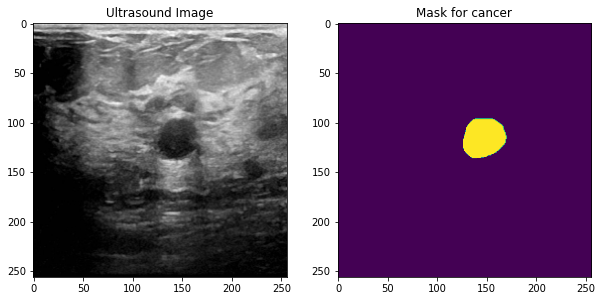

In [36]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))

plt.subplot(1,2,1)

plt.imshow(X_train[2])
plt.title('Ultrasound Image')

plt.subplot(1,2,2)

plt.imshow(y_train[2])
plt.title('Mask for cancer')
plt.show()

In [37]:
# this block essentially performs 2 convolution

def Conv2DBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2DBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2DBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2DBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2DBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2DBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2DBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2DBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2DBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2DBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [38]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = GiveMeUnet(inputs, droupouts = 0.07)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [39]:
retVal = model.fit(np.array(X_train), np.array(y_train), epochs = 50, verbose = 1)

Epoch 1/50
14/14 [==============================] - 104s 7s/step - loss: 0.8140 - accuracy: 0.4306
Epoch 2/50
14/14 [==============================] - 106s 8s/step - loss: 0.5009 - accuracy: 0.9010
Epoch 3/50
14/14 [==============================] - 111s 8s/step - loss: 0.4300 - accuracy: 0.9087
Epoch 4/50
14/14 [==============================] - 111s 8s/step - loss: 0.3981 - accuracy: 0.9097
Epoch 5/50
14/14 [==============================] - 119s 9s/step - loss: 0.3787 - accuracy: 0.9099
Epoch 6/50
14/14 [==============================] - 118s 8s/step - loss: 0.3650 - accuracy: 0.9105
Epoch 7/50
14/14 [==============================] - 117s 8s/step - loss: 0.3529 - accuracy: 0.9112
Epoch 8/50
14/14 [==============================] - 113s 8s/step - loss: 0.3406 - accuracy: 0.9117
Epoch 9/50
14/14 [==============================] - 114s 8s/step - loss: 0.3393 - accuracy: 0.9083
Epoch 10/50
14/14 [==============================] - 121s 9s/step - loss: 0.3567 - accuracy: 0.9045
Epoch 11/

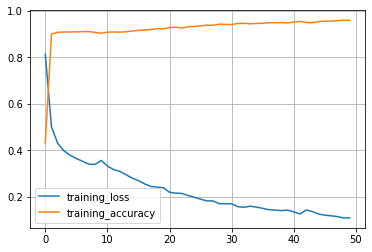

In [40]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [41]:
def predict(model, shape = 256):
    ## getting and proccessing val data
    img = X_test
    mask = y_test
    
    imgProc = img
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

7/7 [==============================] - 10s 1s/step


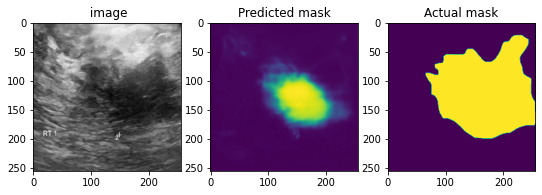

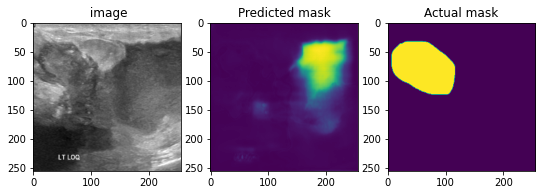

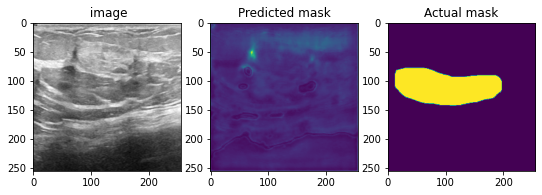

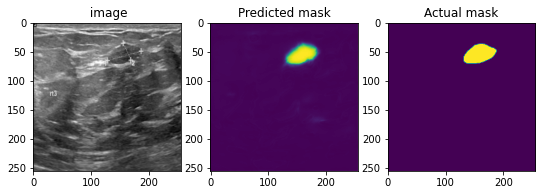

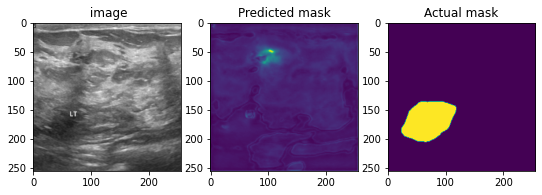

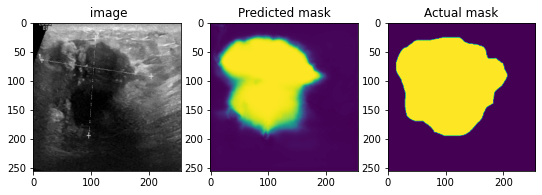

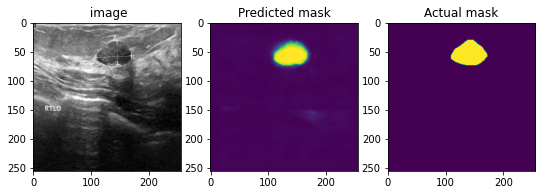

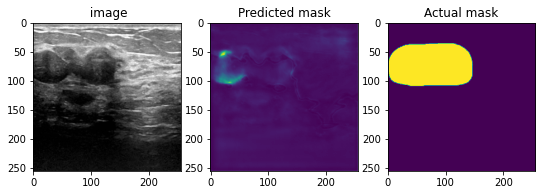

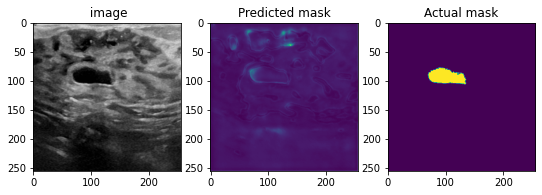

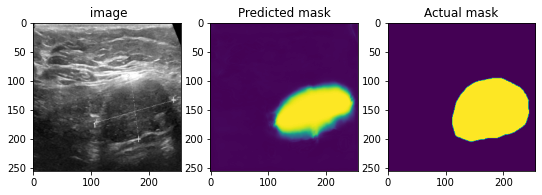

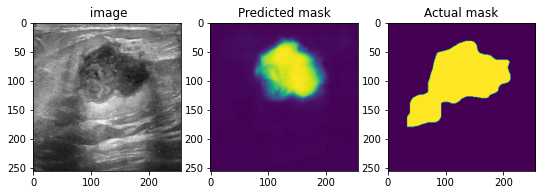

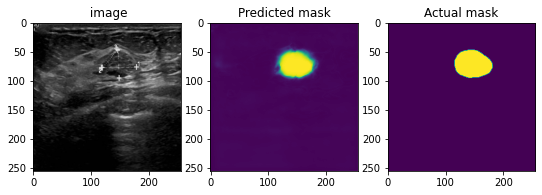

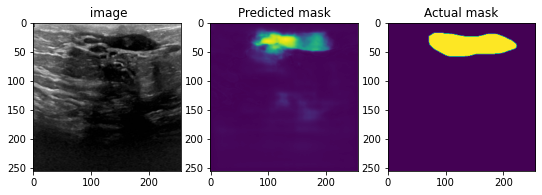

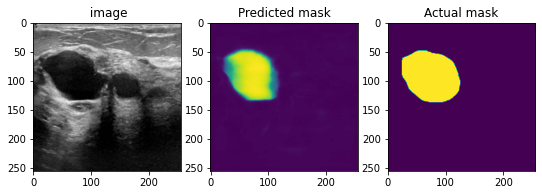

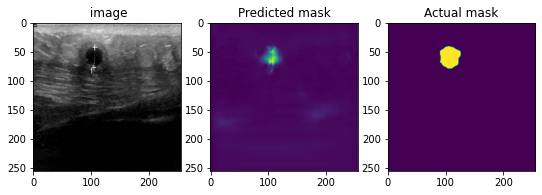

In [43]:
sixteenPrediction, actuals, masks = predict(model)
for i in range(0, 15):
    Plotter(actuals[i], sixteenPrediction[i][:,:,0], masks[i])